# Reproduction number R - basics


The [reproduction number (Wikipedia)](https://en.wikipedia.org/wiki/Basic_reproduction_number) can be thought of as the expected number of cases directly generated by one case in a population. 

In other words, if a person is infected, he will infect $R$ other people during the duration of his illness. If $n$ people are infected, they will affect $Rn$ people. These $Rn$ people will infect $RRn=R^2n$ people, etc. This leads to the exponential growth of the type $nR^s$ with $s$ being the number of periods over which one generation of infected people will infect the next.

One way to represent $R$ is $R = \beta \,\tau $ where $\beta$ represents an average infection-producing contacts per unit time and $\tau$ the infectious period. The infections period for COVID19 is often assumed to be 4 or 5 days.

For exponential growth with case numbers $n(t)$ increasing as 

\begin{equation}
n(t) = n(t_0) R^{t/\tau}, \tag{1}
\end{equation} 

the logarithmic growth rate $K$ can be used to describe the growth: 

\begin{equation}
K = \frac{\mathrm{d} \ln(n)}{\mathrm{d}t}. \tag{2}
\end{equation}

The relationship between $R$ and $K$ is 

\begin{equation}
R = \exp(K\tau) \tag{3} 
\end{equation}

or equivalently $K = \ln(R)/\tau$.

[1] [Basic reproduction number (Wikipedia)](https://en.wikipedia.org/wiki/Basic_reproduction_number)

## Numerical exploration of these relationships - compute R from data exhibiting perfect exponential growth

### 1. Setup synthentic data for exponential growth

In [1]:
# Setup svg rendering in notebook
%config InlineBackend.figure_formats = ['svg']
import numpy as np

In [2]:
n_points = 15         # 15 points (=days) in this data set
t = np.arange(0, n_points, 1)   
tdiff = np.arange(0.5, n_points - 1, 1)  # we need this later
N0 = 1                # infections on day 0
tau = 4               # average infectious time: 4 days
R = 2.1               # R - number of new infections per 
n = N0*(R**(t/tau))   # compute vector n with perfect exponential growth

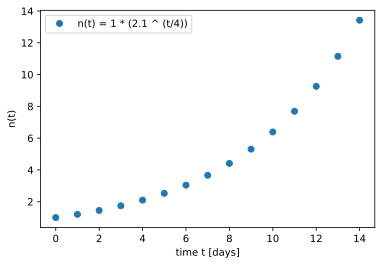

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(t, n, 'o', label=f'n(t) = {N0} * ({R} ^ (t/{tau}))')
ax.legend()
ax.set_xlabel("time t [days]");
ax.set_ylabel("n(t)");

### Compute K and R0 from this data synthetic data

In [5]:
ln_n = np.log(n)    
K = np.diff(ln_n)                 # equation (2)
R_reconstructed = np.exp(K*tau)   # equation (3)

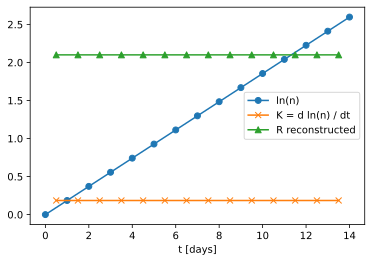

In [6]:
fig, ax = plt.subplots()
ax.plot(t, ln_n, 'o-', label='ln(n)')
ax.plot(tdiff, K, 'x-', label='K = d ln(n) / dt')
ax.plot(tdiff, R_reconstructed, '^-', label='R reconstructed')
ax.set_xlabel('t [days]')
ax.legend()

We expect that the reconstructed value `R_constructed` is the same as R when we computed the synthetic data for n(t):

In [8]:
R_reconstructed

array([2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1])

In [9]:
R

2.1

We turn this into an automatic test:

In [10]:
assert R_reconstructed[0] == R    # checks only first data point
                                  # wehre we have perfect agreement

In [11]:
R_reconstructed - R               # are all values of R_reconstructed
                                  # exactly identical to R?

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -4.44089210e-16,
        4.44089210e-16,  4.44089210e-16,  4.44089210e-16, -1.33226763e-15,
        4.44089210e-16,  4.44089210e-16,  4.44089210e-16,  4.44089210e-16,
       -3.10862447e-15,  4.44089210e-16])

The values are essentialy the same: deviations are of the order of $10^{-15}$. 

We compare all values but allow for some small deviation due to limited machine precision:

In [12]:
assert np.allclose(R_reconstructed, R)

Summary so far: 

- We know the role of reproduction number $R$ in the exponential growth equation (1) 
- If we compute daily data points with exponential growth and grow rate $R$, we can use (2) to reconstruct $R$ from the data.
- This was just a little exercise to gain confidence with that equation.

The potentially harder question is: how do we compute $R$ from _measured_ data which does not show perfect exponential growth.


# Compute R from measured data

### Method 1: 

The bulletin from the Robert Koch institute [2] reports that an average infectious period of $\tau = 4$ days is assumed. Based on that information, the description of the method to compute $R$ (or $R_0$) is [3]

- compute an average $<n>_1$ of daily new infections over 4 days (say days 0 to 3)
- compute an average $<n>_2$ of daily new infections over 4 subsequent days (say days 4 to 7)
- compute the quotient $<n>_2 / <n>_1$ 

The method is references as being reported in [4].

[2] [Robert Koch Institute: Epidemiologisches Bulletin 17 | 2020 23. April 2020, page 13 onwards](https://www.rki.de/DE/Content/Infekt/EpidBull/Archiv/2020/Ausgaben/17_20.html)

[3] "_Bei einer konstanten Generationszeit von 4 Tagen, ergibt sich R als Quotient der Anzahl von Neuerkran- kungen in zwei aufeinander folgenden Zeitabschnitten von jeweils 4 Tagen. Der so ermittelte R-Wert wird dem letzten dieser 8 Tage zugeordnet, weil erst dann die gesamte Information vorhanden ist._"

[4] Wallinga J, Lipsitch M: How generation intervals shape the relationship between growth rates and reproductive numbers. [Proceedings of the Royal Society B:
Biological Sciences 2007;274(1609):599–60](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1766383/)



### Method 2: K from d log(n)/dt and tau

We can also try to use equations (2) and (3) on measured data to extract $R$.

## Approach

To test method 1 and method 2, we will create different types of 'synthetic data' that does not show perfect exponential growth. Yet, we create it with a known (but potentially varying) $R$ values, and see how accurately the different methods can reconstruct these $R$ values from the data.

We test this here with the following types of data:
- Test A: perfect exponential growth (one $R$ value)
- Test B: exponential growth with (step) changes in $R$ over time
- Test C: adding noise to the data points

# Test A
## Test A - method 1

In [13]:
import pandas as pd

In [14]:
s = pd.Series(n, index=t)    # turn numpy array into pandas Series

In [15]:
c = s.diff().dropna()        # compute the change from day to day 
                             # (i.e. dn/dt, time unit is one day
                             # and drop the first value for which can't compute dn/dt
                             # and for which the `diff` method has insert NaN

In [16]:
mean1 = c[0:4].mean()        # take mean over first 4 days
mean2 = c[4:8].mean()        # take mean over next 4 days

In [17]:
quotient = mean2 / mean1     # Compute R as quotient of the two means
quotient

2.1

In [18]:
assert quotient == R

Seems to be okay (for perfect exponential growth)

## Test A - method 2

### Method 2: K from d log(n)/dt and tau

We can also try to use equations (2) and (3) on measured data to extract $R$. We have done this above already, but complete it here for completeness:

In [19]:
K = np.log(s).diff().dropna()
R_reconstructed2 = np.exp(K*tau)
R_reconstructed2

1     2.1
2     2.1
3     2.1
4     2.1
5     2.1
6     2.1
7     2.1
8     2.1
9     2.1
10    2.1
11    2.1
12    2.1
13    2.1
14    2.1
dtype: float64

In [23]:
assert np.allclose(R_reconstructed2.values[0], R)

## Test B  -- with dependent $R$

## More complicated example with time-dependent R

### Step changes in R

First, we define a function `fake_growth` that can create test data which exhibits exponential growth of $n(t)$ for where the growth rate (that depends on $R$) can vary as a function of $t$:

n_points = 500
t = np.arange(0, n_points, 1)
N0 = 1
tau = 4
# R_td = R Time Dependent
R_td = np.zeros(shape=t.shape)
R_td[:n_points//3] = 3
R_td[n_points//3:2*n_points//3] = 2
R_td[2*n_points//3:] = 2.5

# Let's plot this R as a function of time
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(t, R_td, '-o',color='C1', label="time dependent R")
ax.set_xlabel('time [days]');
ax.legend();

In [176]:
def fake_growth(delta_t, Rs, tau: float, N0:int=1, debug:bool=False):
    """Expect 
    - delta_t: a vector with ints: each int indicates for how many days
         R should be constant
    - Rs: a vector with the corresponding values for R
    - tau: a constant for the assumption of the average infectious period
    - N0=1: number of initial cases (for t[0]=0)
    
    Assumes exponential growth according to
    N[i] = N0*(R**(t/tau)) from day i to day i+1 with rate R, where
    R is specified through delta_t and Rs.
        
    Compute and return a time series n. 
    
    Also return a vector of days t and a vector of values `Rvec` 
    that show which R values were used for which interval.
    
    Returns triplet (n, t, Rvec).
    
    """
    def f(R_, t_, tau, c):
        """Exponential growth """
        return c * R_**(t_/tau)
    
    # check assumptions
    assert len(delta_t) == len(Rs)

    # total number of days
    total_days = sum(delta_t) + 1 
    if debug:
        print(f"Looking at {total_days} days.")
    
    # create arrays
    t = np.arange(total_days)
    Rvec = np.zeros(shape=t.shape)
    #dN = np.zeros(shape=t.shape)
    n = np.zeros(shape=t.shape)   # final result of function

    #dN[0] = N0
    counter = 0
    n[counter] = N0

 
    counter += 1
    for dt, this_R in zip(delta_t, Rs):
        if debug:
            print (dt, this_R)
        for i in range(dt):
            n[counter] = f(this_R, i+1, tau, N0)
            assert t[counter] == counter 
            Rvec[counter - 1] = this_R
            counter += 1
        # take the last value as the starting point for next
        # sequence
        N0 = n[counter-1]

    # last point in Rvec is meaningless
    Rvec[counter-1] = np.nan
        
    # n has values for n(t), length total_days
    # t has values for n(t), length total_days
    # Rvec[0] has value for R that was valid from t[0] to t[1] and resulted in
    # value for n[1].
    # Rvec[1] has value for R that was valid from t[1] to t[1] and resulted in
    # value for n[2].
    # Rvec[-1] has np.nan 
        
    return n, t, Rvec
    

n, t, Rvec = fake_growth([3, 2, 1], [2, 3, 4], tau=1, N0=1)

In [177]:
n

array([  1.,   2.,   4.,   8.,  24.,  72., 288.])

In [178]:
t

array([0, 1, 2, 3, 4, 5, 6])

In [179]:
Rvec

array([ 2.,  2.,  2.,  3.,  3.,  4., nan])

In [180]:
def test_fake_growth():
    """ Assume constant growth rate, and expect exponential growth."""
    R_number = 2.1
    tau = 4.5
    N0 = 1.3
    n1, t, Rvec = fake_growth([5, 5, 2, 10], 4*[R_number], tau, N0)
    n2 = N0 * R_number ** (t / tau)   # correct result
    diff = n2 - n1                    # should be zero
    max_err = np.max(np.abs(diff))
    print(f"Max error is {max_err}")
    assert max_err < 1e-14
    return n1, n2

n1, n2 = test_fake_growth();

Max error is 7.105427357601002e-15


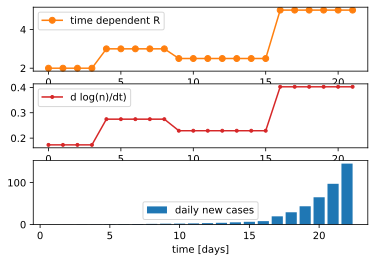

In [181]:
# change growth rate
n_fake, t, Rvec = fake_growth([4, 5, 7, 6], [2, 3, 2.5, 5], tau)

import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.plot(t, Rvec, '-o',color='C1', label="time dependent R")
ax2.plot(t[:-1], np.diff(np.log(n_fake)), '.-', color='C3', label=f'd log(n)/dt)')
n_fake = pd.Series(n_fake)  # turn into pandas.Series to get diff() method
ax3.bar(t, n_fake.diff(), label='daily new cases')
ax3.set_xlabel('time [days]');
ax1.legend(),ax2.legend(), ax3.legend();


In [187]:
Rvec.shape

(23,)

In [188]:
n_fake.shape

(23,)

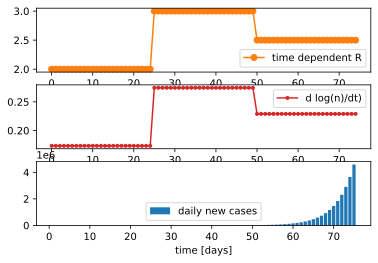

In [206]:
n_fake, t, Rvec = fake_growth([25, 25, 25], [2, 3, 2.5], tau=4, N0=1)

import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.plot(t, Rvec, '-o',color='C1', label="time dependent R")
ax2.plot(t[:-1], np.diff(np.log(n_fake)), '.-', color='C3', label=f'd log(n)/dt)')
n_fake = pd.Series(n_fake)  # turn into pandas.Series to get diff() method
ax3.bar(t, n_fake.diff(), label='daily new cases')
ax3.set_xlabel('time [days]');
ax1.legend(),ax2.legend(), ax3.legend();


In [207]:
df = pd.DataFrame({'R_td' : Rvec, 'n_td' : n_fake, 'c_td' : list(n_fake.diff()[1:]) + [np.nan]})

In [208]:
df

,R_td,n_td,c_td
0,2.0,1.000000e+00,1.892071e-01
1,2.0,1.189207e+00,2.250064e-01
2,2.0,1.414214e+00,2.675793e-01
3,2.0,1.681793e+00,3.182072e-01
4,2.0,2.000000e+00,3.784142e-01
...,...,...,...
71,2.5,8.966653e+06,2.308316e+06
72,2.5,1.127497e+07,2.902554e+06
73,2.5,1.417752e+07,3.649768e+06
74,2.5,1.782729e+07,4.589341e+06


## Method 1: RKI

In [218]:
# Smoothing makes things a lot better:
df['smooth_c'] = df['c_td'].rolling(7, center=True, 
                                    win_type='gaussian', 
                                    min_periods=7).mean(std=3)
# but important to have min_periods the same as the rolling period

df['mean4d'] = df['c_td'].rolling(4).mean()
#df['mean4d'] = df['smooth_c'].rolling(4).mean()

df['R_td-recon'] = df['mean4d'] / df['mean4d'].shift(4)

df[['R_td', 'R_td-recon', 'n_td', 'mean4d']].head(n=60)

,R_td,R_td-recon,n_td,mean4d
0,2.0,NaN,1.000000,NaN
1,2.0,NaN,1.189207,NaN
2,2.0,NaN,1.414214,NaN
3,2.0,NaN,1.681793,0.250000
4,2.0,NaN,2.000000,0.297302
5,2.0,NaN,2.378414,0.353553
6,2.0,NaN,2.828427,0.420448
7,2.0,2.000000,3.363586,0.500000
8,2.0,2.000000,4.000000,0.594604
9,2.0,2.000000,4.756828,0.707107


In [219]:
# df[['R_td', 'R_td-recon', 'n_td', 'mean4d']].tail(n=4)
df[['R_td', 'R_td-recon']].tail(n=4)

,R_td,R_td-recon
72,2.5,2.5
73,2.5,2.5
74,2.5,2.5
75,NaN,NaN


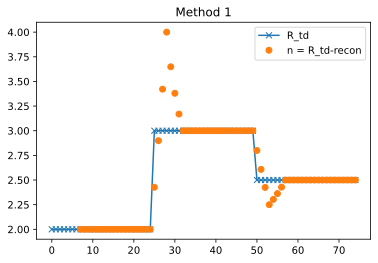

In [220]:
fig, ax = plt.subplots()
ax.plot(t, df['R_td'], '-x', label='R_td')
ax.plot(t, df['R_td-recon'], 'o', label=f'n = R_td-recon')
ax.legend()
ax.set_title('Method 1');

## Method 2

In [233]:
df['K'] = np.log(df['n_td']).diff(periods=1).shift(-1)

#df['K'] = np.log(df['c_td'])

df['R_td-recon2'] = np.exp(df['K'] * tau)


In [234]:
df[['R_td', 'R_td-recon2']].head()

,R_td,R_td-recon2
0,2.0,2.0
1,2.0,2.0
2,2.0,2.0
3,2.0,2.0
4,2.0,2.0


In [235]:
df[['R_td', 'R_td-recon2']].tail()

,R_td,R_td-recon2
71,2.5,2.5
72,2.5,2.5
73,2.5,2.5
74,2.5,2.5
75,NaN,NaN


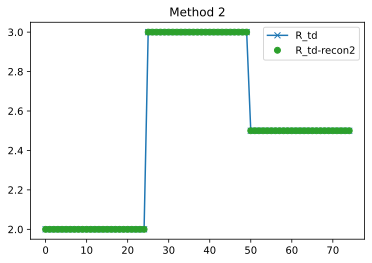

In [236]:
fig, ax = plt.subplots()
ax.plot(t, df['R_td'], '-x', label='R_td')
ax.plot(t, df['R_td-recon2'], 'o', color='C2', label=f'R_td-recon2')
ax.legend()
ax.set_title('Method 2');

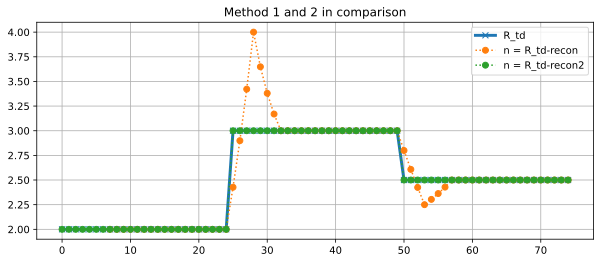

In [237]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(t, df['R_td'], '-x', linewidth=3, label='R_td')
ax.plot(t, df['R_td-recon'], 'o:', color="C1", label=f'n = R_td-recon')
ax.plot(t, df['R_td-recon2'], 'o:', color="C2", label=f'n = R_td-recon2')
ax.legend()
ax.set_title('Method 1 and 2 in comparison');
ax.grid('on')

### Test 2: random noise

In [251]:
N0 = 3
tau = 4
n_fake, t, Rvec = fake_growth([50], [2.0], tau)

noise = np.random.uniform(size=t.shape) - 0.5
# add 10% noise (relative error to actual signal)
n_fake = pd.Series(n_fake * (1 + 0.5 * noise))

B

In [263]:
t.shape

(51,)

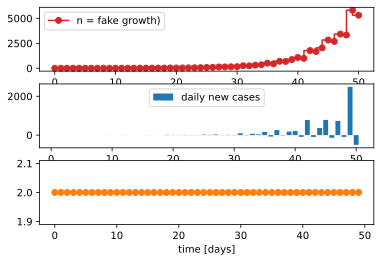

In [254]:

fig, (ax, ax2, ax3) = plt.subplots(3, 1)
ax.step(t, n_fake, 'o-', color='C3', label=f'n = fake growth)')
ax3.plot(t[:-1], R0_td, '-o',color='C1', label="time dependent R0")
ax2.bar(t, n_fake.diff(), label='daily new cases')

ax3.set_xlabel('time [days]');
ax.legend(), 
ax2.legend()

In [277]:
df = pd.DataFrame({'R_td' : Rvec[0:-1], 'n_td' : n_fake[:-1], 'c_td' : n_fake.diff()[:-1]})

In [279]:
df.shape

(50, 3)

In [280]:
df

,R_td,n_td,c_td
0,2.0,1.236267,NaN
1,2.0,1.067654,-0.168613
2,2.0,1.557420,0.489767
3,2.0,1.992323,0.434903
4,2.0,2.056229,0.063906
5,2.0,2.476780,0.420551
6,2.0,2.720345,0.243565
7,2.0,3.751411,1.031066
8,2.0,3.985849,0.234438
9,2.0,5.834828,1.848979


### Method 1: RKI

In [281]:
df['mean4d'] = df['c_td'].rolling(4).mean()
df['R_td-recon'] = df['mean4d'] / df['mean4d'].shift(4)

df[['R_td', 'R_td-recon', 'n_td', 'mean4d']].head(n=20)

,R_td,R_td-recon,n_td,mean4d
0,2.0,NaN,1.236267,NaN
1,2.0,NaN,1.067654,NaN
2,2.0,NaN,1.557420,NaN
3,2.0,NaN,1.992323,NaN
4,2.0,NaN,2.056229,0.204991
5,2.0,NaN,2.476780,0.352282
6,2.0,NaN,2.720345,0.290731
7,2.0,NaN,3.751411,0.439772
8,2.0,2.353304,3.985849,0.482405
9,2.0,2.383071,5.834828,0.839512


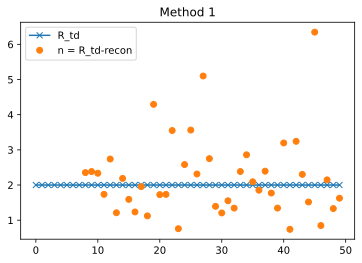

In [284]:
fig, ax = plt.subplots()
ax.plot(t[0:-1], df['R_td'], '-x', label='R_td')
ax.plot(t[0:-1], df['R_td-recon'], 'o', label=f'n = R_td-recon')
ax.legend()
ax.set_title('Method 1');

The noise seems amplified in the reconstructed R.

Let's try some smoothing of the noisy data:

In [285]:

df['smooth_c'] = df['c_td'].rolling(7, center=True, 
                                    win_type='gaussian', min_periods=7).mean(std=3)
df['mean4d'] = df['smooth_c'].rolling(4).mean()


df['R_td-recon'] = df['mean4d'] / df['mean4d'].shift(4)

df[['R_td', 'R_td-recon', 'n_td', 'mean4d']].head(n=20)

,R_td,R_td-recon,n_td,mean4d
0,2.0,NaN,1.236267,NaN
1,2.0,NaN,1.067654,NaN
2,2.0,NaN,1.557420,NaN
3,2.0,NaN,1.992323,NaN
4,2.0,NaN,2.056229,NaN
5,2.0,NaN,2.476780,NaN
6,2.0,NaN,2.720345,NaN
7,2.0,NaN,3.751411,0.466405
8,2.0,NaN,3.985849,0.551217
9,2.0,NaN,5.834828,0.679759


In [289]:
## Test C: Method 2

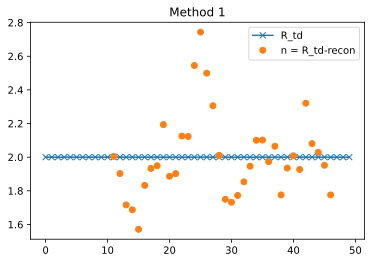

In [287]:
fig, ax = plt.subplots()
ax.plot(t[:-1], df['R_td'], '-x', label='R_td')
ax.plot(t[:-1], df['R_td-recon'], 'o', label=f'n = R_td-recon')
ax.legend()
ax.set_title('Method 1');

## Method 2

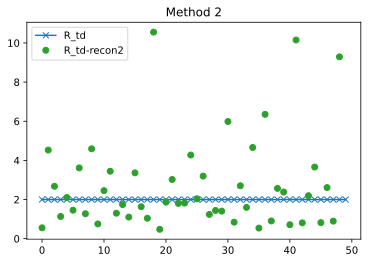

In [296]:
df['K'] = np.log(df['n_td']).diff(periods=1).shift(-1)
df['R_td-recon2'] = np.exp(df['K'] * tau)


fig, ax = plt.subplots()
ax.plot(t[:-1], df['R_td'], '-x', label='R_td')
ax.plot(t[:-1], df['R_td-recon2'], 'o', color='C2', label=f'R_td-recon2')
ax.legend()
ax.set_title('Method 2');



## Method 2 with smooting

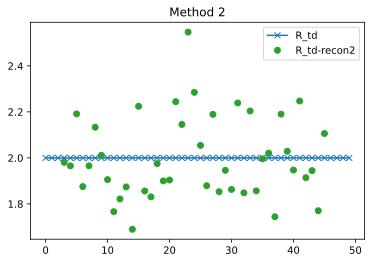

In [297]:
df['smooth_n'] = df['n_td'].rolling(7, center=True, 
                                    win_type='gaussian', min_periods=7).mean(std=3)
df['K'] = np.log(df['smooth_n']).diff(periods=1).shift(-1)
df['R_td-recon2'] = np.exp(df['K'] * tau)


fig, ax = plt.subplots()
ax.plot(t[:-1], df['R_td'], '-x', label='R_td')
ax.plot(t[:-1], df['R_td-recon2'], 'o', color='C2', label=f'R_td-recon2')
ax.legend()
ax.set_title('Method 2');


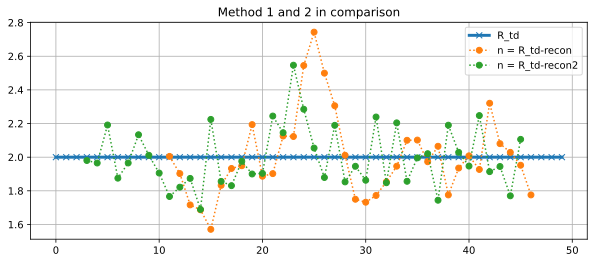

In [299]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(t[:-1], df['R_td'], '-x', linewidth=3, label='R_td')
ax.plot(t[:-1], df['R_td-recon'], 'o:', color="C1", label=f'n = R_td-recon')
ax.plot(t[:-1], df['R_td-recon2'], 'o:', color="C2", label=f'n = R_td-recon2')
ax.legend()
ax.set_title('Method 1 and 2 in comparison');
ax.grid('on')

## Conclusions

1. Use RKI algorithm: seems stable, returns the correct value R (after ~tau days) if R is constant

2. Use smoothing for the case numbers (or the diff of the case numbers) to improve estimates.

3. It is important for the rolling averages (both for the smoothing of the diff, and for the
4-day average) to use all data points, and not to ignore some. If we use 'min_values=' to allow fewer data points, the reconstructed R values show systematic errors at the beginning and end of the interval. 

(Maybe that can be improved.)

Draft algorithm here:

In [ ]:
def compute_R(daily_change, tau=4):
    """Given a time series s, estimate R based on description from RKI [1].
    
    [1] [Robert Koch Institute: Epidemiologisches Bulletin 17 | 2020 23. April 2020]
    https://www.rki.de/DE/Content/Infekt/EpidBull/Archiv/2020/Ausgaben/17_20.html

    Steps: 
    
    1. Compute change from day to day
    2. Take tau-day averages (tau=4 is recommended as of April/May 2020)
    3. divide average from days 4 to 7 by averages from day 0 to 3, and use this data point for day[7]

    """
    # change = s.diff()
    change = daily_change
    mean4d = change.rolling(tau).mean()
    R = mean4d / mean4d.shift(tau)
    R2 = R.shift(-tau)  # this is not the RKI method, but seems more appropriate.
    return R2
    

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t, df['R_td'], '-x', linewidth=3, label='R_td')

ax.plot(t, compute_R(df['n_td'].diff()), 'o:', color="C1", label=f'n = R_td-recon')
ax.legend()
ax.grid('on')

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t, df['R_td'], '-x', linewidth=3, label='R_td')
ax.plot(t, compute_R(df['n_td'].diff()), 'o:', color="C1", label=f'n = R_td-recon')
ax.legend()
ax.grid('on')

In [ ]:
import oscovida
from oscovida import compute_growth_factor

In [ ]:
cases, deaths = oscovida.get_country_data("Germany")


In [ ]:
import math
def min_max_in_past_n_days(series, n, at_least = [0.75, 1.25], alert=[0.5, 100]):
    """Given a time series, find the min and max values in the time series within the last n days.
    
    If those values are within the interval `at_least`, then use the values in at_least as the limits.
    if those values are outside the interval `at_least` then exchange the interval accordingly.
    
    If the values exceed the min and max value in 'alerts', then print an error message.
    Return min, max.
    """
    if n > len(series):
        n = len(series)
        
    series = series.replace(math.inf, math.nan)
        
    min_ = series[-n:].min()
    max_ = series[-n:].max()
    
    if min_ < at_least[0]:
        min_final = min_
    else:
        min_final = at_least[0]
        
    if max_ > at_least[1]:
        max_final = max_
    else:
        max_final = at_least[1]
        
    if max_final > alert[1]:
        print(f"Large value for R_max = {max_final} > {alert[1]} in last {n} days: \n", series[-n:])
    if min_final < alert[0]:
        print(f"Small value for R_min = {min_final} < {alert[0]} in last {n} days: \n", series[-n:])
        
    print(f"DDD: min_={min_}, max_={max_}")
    return min_final, max_final

In [ ]:


cases, deaths = oscovida.get_country_data("Iran")

fig, ax = plt.subplots(1, 1 , figsize=(12, 4))
# change, smooth, smooth2 = oscovida.compute_daily_change(cases)
oscovida.plot_growth_factor(ax, cases, "C1")
# oscovida.plot_growth_factor(ax, deaths, "C0")
diff = cases.diff()
smooth_diff = diff.rolling(9, center=True, win_type='gaussian').mean(std=4)

R = compute_R(smooth_diff)
ax.plot(R.index, R, "-C4", label=r"R (estimated with $\tau$=4 days using RKI algorithm)", linewidth=3)

ax.legend()
min_, max_ = min_max_in_past_n_days(R, 28);
ax.plot([R.index.min(), R.index.max()], [min_, min_], 'b-')
ax.plot([R.index.min(), R.index.max()], [max_, max_], 'b-')
ax.set_ylim([min_, max_]);

In [ ]:
pd.set_option('max_rows', None)

In [ ]:
R[-21:].min()

In [ ]:
ax.plot(R.index, R, "C2", label="R")

In [ ]:
oscovida.overview("Iran");

In [ ]:
def plot_reproducion_number(ax, series, color):
    """Documentation to be added
    """

   
    # data for computation or R
    # change, smooth, smooth2 = oscovida.compute_daily_change(series)
    
    smooth = series.diff().rolling(7, center=True, win_type='gaussian').mean(std=4)
    
    R = compute_R(smooth)
    ax.plot(R.index, R, "-C4", label=r"estimated R (assume $\tau$=4 days, using RKI algorithm)", linewidth=3)

    # choose y limits so that all data points of R in the last 28 days are visible
    min_, max_ = min_max_in_past_n_days(R, 28);
    ax.set_ylim([min_, max_]);

    # Plot ylim interval for debugging
    # ax.plot([R.index.min(), R.index.max()], [min_, min_], 'b-')
    # ax.plot([R.index.min(), R.index.max()], [max_, max_], 'b-')
    
     # get smooth data for growth factor from plot 1 to base this plot on
    (f, f_label) , (f_smoothed, smoothed_label) = compute_growth_factor(series)
    
    label = series.country + " " + series.label + " daily growth factor " + f_label
    ax.plot(f.index, f.values, 'o', color=color, alpha=0.3, label=label)

    label = series.country + " " + series.label + " daily growth factor " + smoothed_label
    ax.plot(f_smoothed.index, f_smoothed.values, '-', color=color, label=label, linewidth=LW)

    ax.set_ylabel("R and daily growth factor")
    # plot line at 0
    ax.plot([series.index.min(), series.index.max()], [1.0, 1.0], '-k') # label="critical value"
    ax.legend()
    return ax


In [ ]:
fig, ax = plt.subplots(1, 1 , figsize=(12, 4))
LW = oscovida.LW
plot_reproducion_number(ax, cases, 'C1')
LW = oscovida.LW